In [1]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions_controlled_conditions import *

import datetime

pandas version is 1.3.2


In [2]:
# Read data and parameters from excel files

xl = pd.ExcelFile('C:/Users/meiro/Desktop/GitHub/Model/Meiron_model/data/Parameters.xlsx')
x2 = pd.ExcelFile('C:/Users/meiro/Desktop/GitHub/Model/Meiron_model/data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

# Import data into df2
df2 = x2.parse('Indoor')

df2.head()

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,Unnamed: 38,N_Saturation
0,0.0,1,0,0.0,i,"2019,3,12,13,0","2019,3,12,13,0","2019,3,12,13,0",0.750,NaN,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,yes
1,0.7,1,0,0.0,f,"2019,3,12,13,0","2019,3,12,13,0","2019,3,19,13,0",0.753,50.0,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,yes
2,1.0,1,1,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.144,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes
3,2.0,1,2,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.153,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes
4,3.0,1,3,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.159,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes


In [3]:
# Process data

# Convert Time (from a form of YYYY,M,DD,HH,mm) into hours (from begining of experiment)

T = []
for i in df2['Sample'][:]:
    T1 = df2['Timei'][df2['Sample'].values.tolist().index(i)]
    T2 = df2['Time'][df2['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
df2['T'] = T

# Make a temp DF (df2_Reduced) by filtering the original df - removing data of:
# 1. acclimation stage, 2. begining of experiments (which is constant), and 3. weeks above 3 (irrelevant here), and other irrelevant data that was excluded

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') &(df2.Comment != 'Exclude')]

df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,Unnamed: 38,N_Saturation,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
14,4.7,1,4,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,5.2,...,2000.0,4.0,2000.0,No,NaN,NaN,NaN,NaN,no,165
15,5.7,1,5,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,4.8,...,2000.0,4.0,2000.0,No,NaN,NaN,NaN,NaN,no,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,145.7,5,5,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.321,5.0,...,500.0,168.0,1500.0,No,NaN,NaN,NaN,NaN,yes,501
469,146.7,5,6,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.297,5.0,...,500.0,168.0,1500.0,No,NaN,NaN,NaN,NaN,yes,501
470,147.7,5,7,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.357,5.0,...,200.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,501
471,148.7,5,8,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.336,5.0,...,200.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,501


In [4]:
# list of parameters
miu = 0.03
lossess20 = 0.004
Nintmax = 4.5
Nintcrit = 2.3 
dNextoutdt = 0.015
Ks = 23
Vmax = 60
KI = 16
K0 = 2
Ka = 0.1
Smin = 0
Sopt = 28
Smax = 50
Topt = 18
Tmax = 35.9
n = 5.1

In [5]:
# list of parameters - based on indoor system culibration - Nintmax between 4.5-5
miu = 0.03
lossess20 = 0.001
Nintmax = 4.8
Nintcrit = 1.55
dNextoutdt = 0.013
Ks = 12.1
Vmax = 53.2
KI = 32.9
K0 = 1.3
Ka = 0.033



Treatment: 1000/1/168
Number of samples:
m: 27 Nint: 19 Next: 26
7.0
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
336.0
Duration
Fertilizing efficiency of: 0.41307411949375145in week 1
Fertilizing efficiency of: 0.41085240259080974in week 2
Fertilizing efficiency of: 0.41045145217666495in week 3

Treatment: 500/2/168
Number of samples:
m: 66 Nint: 38 Next: 90
3.5
0.0
Starting point
84.0
Period


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
252.0
Period
336.0
Duration
420.0
Period
Fertilizing efficiency of: 0.5862172729856836in week 1
Fertilizing efficiency of: 0.6159046804739268in week 2
Fertilizing efficiency of: 0.6212929065965886in week 3

Treatment: 500/3/168
Number of samples:
m: 18 Nint: 12 Next: 18
2.3333333333333335
0.0
Starting point
56.0
Period
112.0
Period
168.0
Duration


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


224.0
Period
280.0
Period
336.0
Duration
392.0
Period
448.0
Period
Fertilizing efficiency of: 0.5331339454523991in week 1
Fertilizing efficiency of: 0.5416155857852457in week 2
Fertilizing efficiency of: 0.5418968383633728in week 3

Treatment: 2000/1/168


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Number of samples:
m: 0 Nint: 0 Next: 0
7.0
0.0
Starting point
168.0
Duration
336.0
Duration
Fertilizing efficiency of: 0.3137455352656339in week 1
Fertilizing efficiency of: 0.3276368655003703in week 2
Fertilizing efficiency of: 0.3293892439941688in week 3

Treatment: 200/5/168
Number of samples:
m: 0 Nint: 0 Next: 0
1.4
0.0
Starting point
34.0
Period
68.0
Period
102.0
Period


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


136.0
Period
170.0
Duration
204.0
Period
238.0
Period
272.0
Period
306.0
Period
340.0
Duration
374.0
Period
408.0
Period
442.0
Period
476.0
Period
Fertilizing efficiency of: 0.762026422836751in week 1
Fertilizing efficiency of: 0.8349340707318157in week 2
Fertilizing efficiency of: 0.8250845489546299in week 3


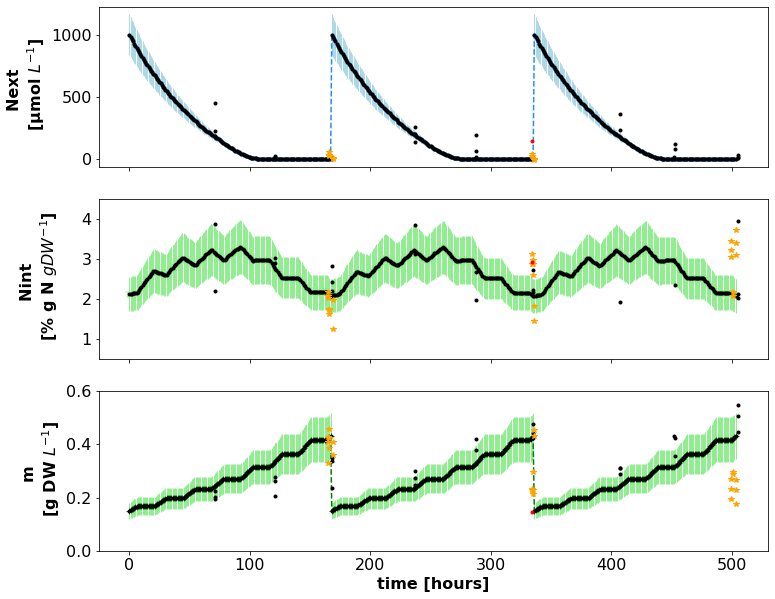

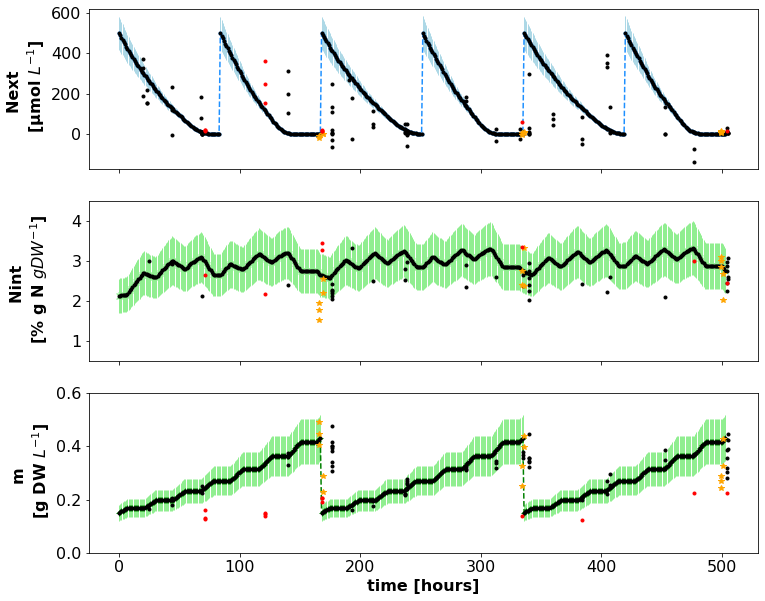

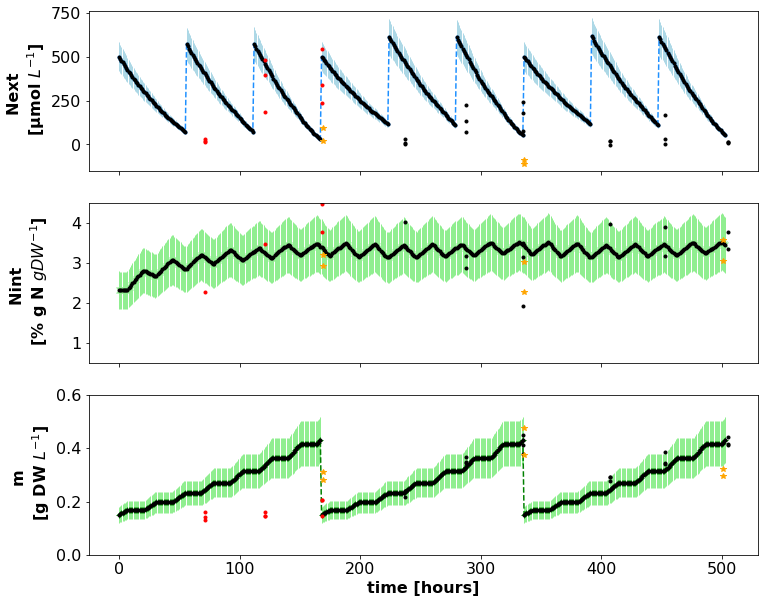

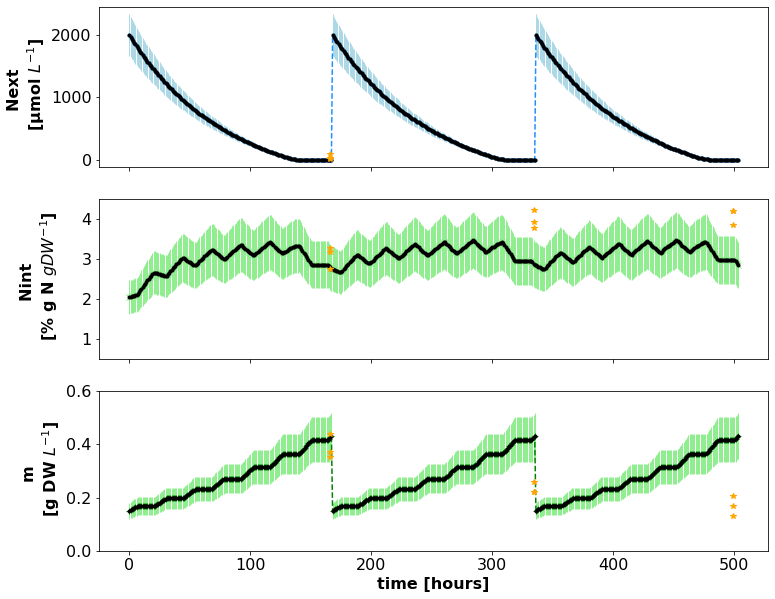

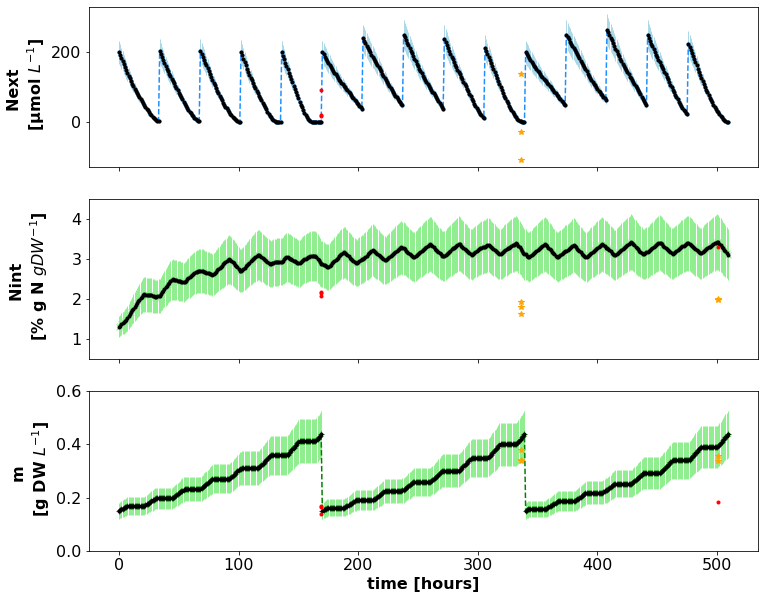

In [6]:
# Simulationm + experimental data from short fertilizing treatments (data from sporulation events was excluded)
# Calibration data - experiments #3 and #4 (black)
# Validation data - experiments #1, #2 and #5 (orange)

# We first produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment
# Next, we organize the experimental data in three groups - calibration, validation and sporulation
# Finally, we plot simulations for each treatment and add the experimental results as dots/stars

TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']
Nint0All = ['2.12','2.13','2.32','2.05','1.3']

Temp = 22
S = 39 # fix salinity function and S=40

df2_cal = df2_Reduced[(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Sporulated == 'No')]
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Sporulated == 'No')]
df2_spor = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Duration == 168) & (df2_Reduced.Sporulated == 'Yes')&(df2_Reduced.Comment != 'Exclude')]


for i in Treatments:
    print('\nTreatment: ' + str(i))
    
    # calibration data
    df2Temp_cal = df2_cal[(df2_Reduced.Treatment == i)]
    mTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['DW']
    mTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['T']
    NintTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['N']
    NintTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['T']
    NextTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['NH4']
    NextTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['T']
    
    # validation data
    df2Temp_val = df2_val[(df2_Reduced.Treatment == i)]
    mTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['DW']
    mTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['T']
    NintTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['N']
    NintTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['T']
    NextTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['NH4']
    NextTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['T']
    mTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['DW']
    mTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['T']
    NintTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['N']
    NintTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['T']
    NextTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['NH4']
    NextTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['T']
    
    # sporulation data
    del mTimeTemp_spor
    df2Temp_spor = df2_spor[(df2_spor.Treatment == i)]
    mTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['DW']
    mTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['T']
    NintTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['N']
    NintTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['T']
    NextTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['T']
    mTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['DW']
    mTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['T']
    NintTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['N']
    NintTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['T']
    NextTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['T']
    
    print('Number of samples:\nm: ' + str(len(mTimeTemp_cal)) + ' Nint: ' + str(len(NintTimeTemp_cal)) + ' Next: ' + str(len(NextTimeTemp_cal)))
    
    # Amplitude (uM NH4) / Period (times per week) / Duration (hours) parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in hours
    print(Period)
    Duration = Tr[2]/24
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Duration*3 #here fertilizing duration is a whole week, like cultivation length
    count_periods = 0 # used to follow cultivation events within each week
    
    # hour = 0 is 1pm 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the current Next + the Amplitude, 
    # m0 to the end of previous solution of ode()
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar. 
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 1am = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the inital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 (for example 80 umol photons per m^2 per second)
    # then replace the lines above with the following line
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in np.arange(0,n_days*24,round(Period*24,0)):
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
        
        if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
            count_periods = count_periods + 1
            
            if count_periods == Tr[1]:
                print('Duration')
                # reset everything, except Nint
                Nint_0 = NINT[-1][-1]
                Next_0 = Amplitude
                m_0 = m0
                count_periods = 0
            else:
                # period passed, not Duration
                # add amplitude, keep going 
                print('Period')
                Next_0 = NEXT[-1][-1] + Amplitude
                Nint_0 = NINT[-1][-1]
                m_0 = M[-1][-1]
   
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        t = np.arange(hour, hour+Period*24) # every time we solve ODE for 24 hours * Period

        x = odeint(controlled_N_constST,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Z,KI,K0,Ka,
                losses20,teta,umol_to_percent_DW,I0,Temp),printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

    TModAll.append(TT)
    
    #model data
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
    #Calibration experimental data
    mExpAllTimes_cal.append(mTimeTemp_cal)
    NintExpAllTimes_cal.append(NintTimeTemp_cal)
    NextExpAllTimes_cal.append(NextTimeTemp_cal)
       
    #Valiaation experimental data
    mExpAllTimes_val.append(mTimeTemp_val)
    NintExpAllTimes_val.append(NintTimeTemp_val)
    NextExpAllTimes_val.append(NextTimeTemp_val)
    
    #Sporulation experimental data
    if len(mTimeTemp_spor) > 0:
        mExpAllTimes_spor.append(mTimeTemp_spor)
        NintExpAllTimes_spor.append(NintTimeTemp_spor)
        NextExpAllTimes_spor.append(NextTimeTemp_spor)
    
    # error bars according to calibration error
    yerrm1,yerrNext1,yerrNint1 = [],[],[]
    for i in m_model:
        yerrm1.append(0.202*i)
    for i in Nint_model:
        yerrNint1.append(0.202*i)
    for i in Next_model:
        yerrNext1.append(0.165*i)

    
    # plot simulation + experimental data for each treatment
    #plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,tNint=NintTimeTemp_cal,m=mTemp_cal,tm=mTimeTemp_cal,Next=NextTemp_cal,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)
    plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,yerrNint=yerrNint1,tNint=NintTimeTemp_cal,m=mTemp_cal,yerrm=yerrm1,tm=mTimeTemp_cal,Next=NextTemp_cal,yerrNext=yerrNext1,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)
    
    # Fertilizing efficiency by model
    As = Nint_model[167] * m_model[167] / 100 - Nint_model[0] * m_model[0] / 100
    Ad = Tr[0] * Tr[1] / 1000 * 14 / 1000

    Ef = As / Ad
    print('Fertilizing efficiency of: ' + str(Ef) + 'in week 1')
    
    As = Nint_model[335] * m_model[335] / 100 - Nint_model[0] * m_model[0] / 100

    Ef = As / Ad
    print('Fertilizing efficiency of: ' + str(Ef) + 'in week 2')
    
    As = Nint_model[503] * m_model[503] / 100 - Nint_model[0] * m_model[0] / 100

    Ef = As / Ad
    print('Fertilizing efficiency of: ' + str(Ef) + 'in week 3')

In [7]:
# Calibration data error - step 1: calculte model prediction for each measurement

# This cell adjusts measurment time to model durations - so that maximum biomass measurements
# are compared to maximum biomass predictions and not to the initial stocking density (m0)


# constrain times to end at 504 hours
TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)): # loops over 5 treatments
    print(i)
    for j in range(len(TModAll[i])): # Loops over periods in each treatment
        Ttemp = TModAll[i][j]
        for k in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

mExpAllTimes_cal_new = []
for i in range(len(TModAll)):
    
    # Calculate m model predictions - if time is out of bounderies, maximal model value is chosen
    gm = interpolate.interp1d(TModAllOrg[i], mModAll[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        elif j >= 336 and j < 345:
            j = 335.9
        elif j > 504:
            j = 504
        mModReduced.append(gm(j-1))
    mModReducedAll.append(mModReduced)  
    
    # Calculate Nint model predictions - if time is out of bounderies, maximal model value is chosen
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j-1))
    NintModReducedAll.append(NintModReduced)
    
    # Calculate Next model predictions - if time is out of bounderies, maximal model value is chosen
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j-1))
    NextModReducedAll.append(NextModReduced)

0
1
2
3
4


In [8]:
# Calibration data error - step 2: calculte errors for each variable

mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    # Biomass
    
    df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]

    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample: # loop over all samples
        mexp = df2m.DW # measured m
        mmod = mModReducedAll[i] # predicted m
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        print('Relative Error: ' + str(round(float(mSRE[k]**0.5),3)) + '\n')
        mSRE_All.append((((mexp.iloc[k]-mmod[k])/mmod[k])**2)) # All Square Relative Errors
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3) # Root Mean Square relative error
    
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    # Internal N
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]

    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample: # loop over all samples
        Nintexp = df2Nint.N # measured Nint
        Nintmod = NintModReducedAll[i] # predicted Nint
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        NintSRE_All.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # All Square Relative Errors
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3) #RMSRE
    
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    # External N
    df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]
    print('\nNext\n')
    print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    k = 0
    for j in df2Next.Sample:
        Nextexp = df2Next.NH4
        if Nextexp.iloc[k] < 0:
            Nextexp.iloc[k] = 0
        Nextmod = NextModReducedAll[i]
        NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
        print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENext = round((np.mean(NextSRE))**0.5,3)
    NextSRE_All.append(NextSRE)
    print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

Treatment: 1000/1/168

m

Number of samples: 27

Sample #91
Measured biomass: 0.201
Modeled biomass: 0.238

Relative Error: 0.154

Sample #91
Measured biomass: 0.261
Modeled biomass: 0.331

Relative Error: 0.212

Sample #92
Measured biomass: 0.225
Modeled biomass: 0.238

Relative Error: 0.053

Sample #92
Measured biomass: 0.276
Modeled biomass: 0.331

Relative Error: 0.167

Sample #93
Measured biomass: 0.195
Modeled biomass: 0.238

Relative Error: 0.18

Sample #93
Measured biomass: 0.204
Modeled biomass: 0.331

Relative Error: 0.384

Sample #91
Measured biomass: 0.336
Modeled biomass: 0.43

Relative Error: 0.219

Sample #92
Measured biomass: 0.348
Modeled biomass: 0.43

Relative Error: 0.191

Sample #93
Measured biomass: 0.234
Modeled biomass: 0.43

Relative Error: 0.456

Sample #101
Measured biomass: 0.246
Modeled biomass: 0.232

Relative Error: 0.061

Sample #101
Measured biomass: 0.327
Modeled biomass: 0.327

Relative Error: 0.001

Sample #102
Measured biomass: 0.3
Modeled biomass: 

IndexError: list index out of range

In [ ]:
# list of parameters - based on short-duration indoor system culibration - Nintmax between 4.5-5
miu = 0.03
lossess20 = 0.003
Nintmax = 4.6
Nintcrit = 1.68
dNextoutdt = 0.002
Ks = 28.1
Vmax = 56.4
KI = 38.1
K0 = 2.3
Ka = 0.129

In [ ]:
# Simulationm + experimental data from short fertilizing treatments (data from sporulation events was excluded)
# Calibration data - experiments #3 and #4 (black)
# Validation data - experiments #1, #2 and #5 (orange)

# We first produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment
# Next, we organize the experimental data in three groups - calibration, validation and sporulation
# Finally, we plot simulations for each treatment and add the experimental results as dots/stars

TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']
Nint0All = ['2.12','2.13','2.32','2.05','1.3']

Temp = 22
S = 39 # fix salinity function and S=40

df2_cal = df2_Reduced[(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Sporulated == 'No')]
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Sporulated == 'No')]
df2_spor = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Duration == 168) & (df2_Reduced.Sporulated == 'Yes')&(df2_Reduced.Comment != 'Exclude')]


for i in Treatments:
    print('\nTreatment: ' + str(i))
    
    # calibration data
    df2Temp_cal = df2_cal[(df2_Reduced.Treatment == i)]
    mTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['DW']
    mTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['T']
    NintTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['N']
    NintTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['T']
    NextTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['NH4']
    NextTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['T']
    
    # validation data
    df2Temp_val = df2_val[(df2_Reduced.Treatment == i)]
    mTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['DW']
    mTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['T']
    NintTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['N']
    NintTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['T']
    NextTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['NH4']
    NextTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['T']
    mTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['DW']
    mTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['T']
    NintTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['N']
    NintTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['T']
    NextTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['NH4']
    NextTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['T']
    
    # sporulation data
    del mTimeTemp_spor
    df2Temp_spor = df2_spor[(df2_spor.Treatment == i)]
    mTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['DW']
    mTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['T']
    NintTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['N']
    NintTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['T']
    NextTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['T']
    mTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['DW']
    mTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['T']
    NintTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['N']
    NintTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['T']
    NextTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['T']
    
    print('Number of samples:\nm: ' + str(len(mTimeTemp_cal)) + ' Nint: ' + str(len(NintTimeTemp_cal)) + ' Next: ' + str(len(NextTimeTemp_cal)))
    
    # Amplitude (uM NH4) / Period (times per week) / Duration (hours) parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in hours
    print(Period)
    Duration = Tr[2]/24
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Duration*3 #here fertilizing duration is a whole week, like cultivation length
    count_periods = 0 # used to follow cultivation events within each week
    
    # hour = 0 is 1pm 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the current Next + the Amplitude, 
    # m0 to the end of previous solution of ode()
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar. 
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 1am = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the inital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 (for example 80 umol photons per m^2 per second)
    # then replace the lines above with the following line
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in np.arange(0,n_days*24,round(Period*24,0)):
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
        
        if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
            count_periods = count_periods + 1
            
            if count_periods == Tr[1]:
                print('Duration')
                # reset everything, except Nint
                Nint_0 = NINT[-1][-1]
                Next_0 = Amplitude
                m_0 = m0
                count_periods = 0
            else:
                # period passed, not Duration
                # add amplitude, keep going 
                print('Period')
                Next_0 = NEXT[-1][-1] + Amplitude
                Nint_0 = NINT[-1][-1]
                m_0 = M[-1][-1]
   
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        t = np.arange(hour, hour+Period*24) # every time we solve ODE for 24 hours * Period

        x = odeint(controlled_N_constST,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Z,KI,K0,Ka,
                losses20,teta,umol_to_percent_DW,I0,Temp),printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

    TModAll.append(TT)
    
    #model data
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
    #Calibration experimental data
    mExpAllTimes_cal.append(mTimeTemp_cal)
    NintExpAllTimes_cal.append(NintTimeTemp_cal)
    NextExpAllTimes_cal.append(NextTimeTemp_cal)
       
    #Valiaation experimental data
    mExpAllTimes_val.append(mTimeTemp_val)
    NintExpAllTimes_val.append(NintTimeTemp_val)
    NextExpAllTimes_val.append(NextTimeTemp_val)
    
    #Sporulation experimental data
    if len(mTimeTemp_spor) > 0:
        mExpAllTimes_spor.append(mTimeTemp_spor)
        NintExpAllTimes_spor.append(NintTimeTemp_spor)
        NextExpAllTimes_spor.append(NextTimeTemp_spor)
    
    # error bars according to calibration error
    yerrm1,yerrNext1,yerrNint1 = [],[],[]
    for i in m_model:
        yerrm1.append(0.202*i)
    for i in Nint_model:
        yerrNint1.append(0.202*i)
    for i in Next_model:
        yerrNext1.append(0.165*i)

    
    # plot simulation + experimental data for each treatment
    #plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,tNint=NintTimeTemp_cal,m=mTemp_cal,tm=mTimeTemp_cal,Next=NextTemp_cal,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)
    plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,yerrNint=yerrNint1,tNint=NintTimeTemp_cal,m=mTemp_cal,yerrm=yerrm1,tm=mTimeTemp_cal,Next=NextTemp_cal,yerrNext=yerrNext1,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)